# Dependancies

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from keras import *

import numpy as np
import pandas as pd

# Data

In [0]:
path_to_data = "/content/Full Database for TCRs.csv"

In [0]:
data = pd.read_csv(path_to_data)
data = data.dropna()
data = data.reset_index(drop=True)

data_epitope = data['Epitope'][:60001]
data_v = data['V'][:60001]
data_j = data['J'][:60001]
data_cdr3 = data['CDR3'][:60001]

In [0]:
MAX_LENGTH = 41
def encoder_protien(data_frame, start=0):
  ######################################################
  #Encoding into Numbers
  ######################################################

  encoder_dict = {'+':1,'a':2,'b':3,'c':4,'d':5,'e':6,'f':7,'g':8,'h':9,'i':10,
             'j':11,'k':12,'l':13,'m':14,'n':15,'o':16,'p':17,'q':18,'r':19,'s':20,
             't':21,'u':22,'v':23,'w':24,'x':25,'y':26,'z':27,'-':28,'*':29,'1':30,
             '2':31,'3':32,'4':33,'5':34,'6':35,'7':36,'8':37,'9':38,'0':39,'=':40}

  output = []
  max_length = 0

  for sequence in data_frame:
    a = len(sequence)
    if (a > max_length):
      max_length = a+2

  for sequence in data_frame:
    sequence_temp = []
    
    if (start == 0):
      sequence = sequence + '='
    elif (start == 1):
      sequence = '=' + sequence
    else:
      sequence = sequence

    for protien in sequence:
      sequence_temp.append(encoder_dict[protien.lower()])

    for i in range(max_length-len(sequence_temp)):
      sequence_temp.append(0)

    output.append(sequence_temp)

  output = np.asarray(output)
  
  ######################################################
  #Encoding into One Hot
  ######################################################

  one_hot_encoder_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,
                          17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                          31,32,33,34,35,36,37,38,39,40]
  one_hot_encoder_list = np.asarray(one_hot_encoder_list)
  b = np.zeros((one_hot_encoder_list.size, one_hot_encoder_list.max()+1))
  b[np.arange(one_hot_encoder_list.size),one_hot_encoder_list] = 1
  dict_for_oneHot = b.tolist()

  real_output = []
  for array in output:
    one_item = []
    for num in array:
      current_one_hot = dict_for_oneHot[num]
      one_item.append(current_one_hot)
    real_output.append(one_item)

  real_output = np.asarray(real_output)

  return real_output

In [0]:
epitope_array = encoder_protien(data_epitope,start=0)
cdr3_array_input = encoder_protien(data_cdr3, start=1)
cdr3_array = encoder_protien(data_cdr3, start=2)

# Model / Training

In [0]:
from keras.models import *
from keras.layers import *

num_encoder_tokens = 41
num_decoder_tokens = 41
latent_dimension = 40
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dimension, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dimension, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [0]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, None, 41)     0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, None, 41)     0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   [(None, 40), (None,  13120       input_13[0][0]                   
__________________________________________________________________________________________________
lstm_10 (LSTM)                  [(None, None, 40), ( 13120       input_14[0][0]                   
                                                                 lstm_9[0][1]               

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model.fit([epitope_array, cdr3_array_input], cdr3_array,
          epochs=20,
          validation_split=0.2, shuffle=True)

Train on 48000 samples, validate on 12001 samples
Epoch 1/20
48000/48000 [==============================] - 70s 1ms/step - loss: 0.7519 - acc: 0.7964 - val_loss: 0.8407 - val_acc: 0.7675
Epoch 2/20
48000/48000 [==============================] - 67s 1ms/step - loss: 0.5643 - acc: 0.8354 - val_loss: 0.8031 - val_acc: 0.7785
Epoch 3/20
48000/48000 [==============================] - 71s 1ms/step - loss: 0.5348 - acc: 0.8449 - val_loss: 0.7516 - val_acc: 0.7867
Epoch 4/20
48000/48000 [==============================] - 70s 1ms/step - loss: 0.5188 - acc: 0.8493 - val_loss: 0.7049 - val_acc: 0.7985
Epoch 5/20
48000/48000 [==============================] - 69s 1ms/step - loss: 0.5078 - acc: 0.8521 - val_loss: 0.6773 - val_acc: 0.8053
Epoch 6/20
48000/48000 [==============================] - 69s 1ms/step - loss: 0.4997 - acc: 0.8544 - val_loss: 0.6578 - val_acc: 0.8116
Epoch 7/20
48000/48000 [==============================] - 73s 2ms/step - loss: 0.4932 - acc: 0.8565 - val_loss: 0.6338 - val_acc

In [0]:
model.save('/content/encoder_model2.hdf5')

# Prediction and Visualization

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)

In [0]:
decoder_state_input_h = Input(shape=(latent_dimension,))
decoder_state_input_c = Input(shape=(latent_dimension,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [0]:
def predictor(input_seq):
  states_value = encoder_model.predict(input_seq.reshape(1,input_seq.shape[0],input_seq.shape[1]))
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  target_seq[0, 0, 0] = 1

  decoded_list = []
  condition = True
  while (condition):
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    decoded_list.append(sampled_token_index)

    if (sampled_token_index == 41 or len(decoded_list) == 44):
      condition = False
    
    target_seq = np.zeros((1,1, num_decoder_tokens))
    target_seq[0,0,sampled_token_index] = 1

    states_value = [h,c]
  
  encoder_dict = {'+':1,'a':2,'b':3,'c':4,'d':5,'e':6,'f':7,'g':8,'h':9,'i':10,
             'j':11,'k':12,'l':13,'m':14,'n':15,'o':16,'p':17,'q':18,'r':19,'s':20,
             't':21,'u':22,'v':23,'w':24,'x':25,'y':26,'z':27,'-':28,'*':29,'1':30,
             '2':31,'3':32,'4':33,'5':34,'6':35,'7':36,'8':37,'9':38,'0':39,'=':40}
  inverse_dict = {v: k for k, v in encoder_dict.items()}
  output = ''
  for i in decoded_list:
    if (i == 0):
      continue
    output += inverse_dict[i]
  return output.upper()


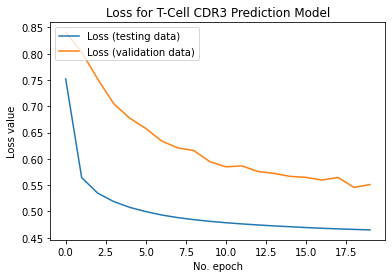

In [0]:
plt.plot(history.history['loss'], label='Loss (testing data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for T-Cell CDR3 Prediction Model')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

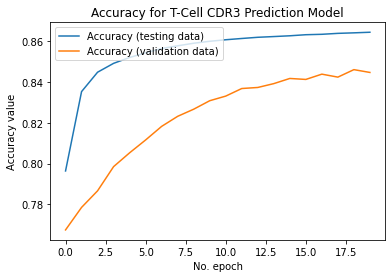

In [0]:
plt.plot(history.history['acc'], label='Accuracy (testing data)')
plt.plot(history.history['val_acc'], label='Accuracy (validation data)')
plt.title('Accuracy for T-Cell CDR3 Prediction Model')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()